In [1]:
import pandas as pd # a Python library for data manipulation and analysis, specifically tables and time series
import matplotlib.pyplot as plt # collection of functions that enable matplotlib, a vizualisation library, to work. Each function makes a change to a figure
import numpy as np # a Python library for scientific computing
import seaborn as sns # a Python library for data visualization (based on matplotlib). It provides a high-level interface for drawing attractive and informative statistical graphics. 
import scipy.stats
import statsmodels.api as sm
from scipy import stats
from scipy.stats import pearsonr
from scipy.stats import f_oneway
from scipy.stats import chi2
from scipy.stats import f
from statsmodels.graphics.mosaicplot import mosaic
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, roc_auc_score, roc_curve


file = "finaldataset.xlsx"

stats_df = pd.read_excel(file)

stats_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137 entries, 0 to 136
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            137 non-null    datetime64[ns]
 1   Birth_Week      137 non-null    int64         
 2   Birth_Month     137 non-null    int64         
 3   CurDayOunces    137 non-null    float64       
 4   PrevDayOunces   137 non-null    float64       
 5   Feeding_Type    137 non-null    object        
 6   NumbofDayNaps   137 non-null    int64         
 7   Weight_Pounds   137 non-null    float64       
 8   NighttimeSleep  137 non-null    float64       
 9   DaytimeSleep    137 non-null    float64       
 10  GoodBadSleep    137 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(4), object(1)
memory usage: 11.9+ KB


In [2]:
# Drop our one string column so we can do a correlation analysis
quant_df = stats_df.drop(columns=["Feeding_Type","Date","Birth_Week","Weight_Pounds","GoodBadSleep","Birth_Month"])
quant_df.corr()['NighttimeSleep'].sort_values()

DaytimeSleep     -0.652721
NumbofDayNaps     0.251391
CurDayOunces      0.534690
PrevDayOunces     0.546197
NighttimeSleep    1.000000
Name: NighttimeSleep, dtype: float64

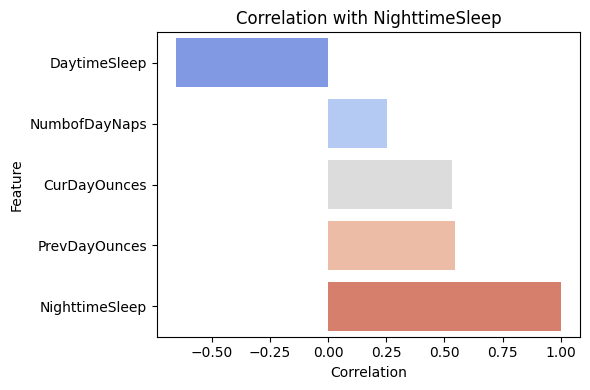

In [3]:
correlations = quant_df.corr()['NighttimeSleep'].sort_values().reset_index()
correlations.columns = ['Feature', 'Correlation']

plt.figure(figsize=(6, 4))
correlations['hue'] = correlations['Feature']  # dummy hue column

sns.barplot(
    x='Correlation',
    y='Feature',
    hue='hue',
    data=correlations,
    palette='coolwarm',
    dodge=False,
    legend=False
)
plt.title('Correlation with NighttimeSleep')
plt.tight_layout()
plt.show()

# Linear Regression and P-Value

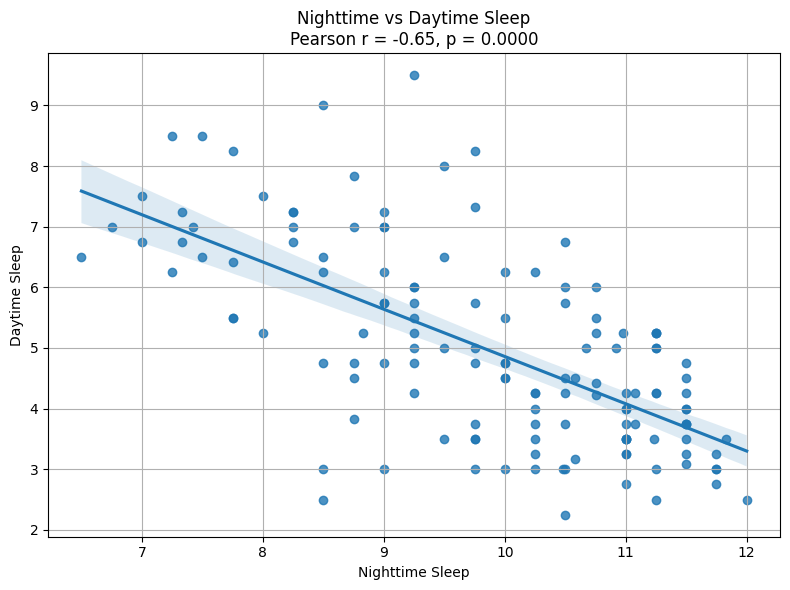

In [4]:
# Calculate Pearson correlation and p-value
pearson_coef, p_value = stats.pearsonr(stats_df['NighttimeSleep'], stats_df['DaytimeSleep'])

# Plotting our lin reg line
plt.figure(figsize=(8, 6))
sns.regplot(x='NighttimeSleep', y='DaytimeSleep', data=stats_df)
plt.title(f'Nighttime vs Daytime Sleep\nPearson r = {pearson_coef:.2f}, p = {p_value:.4f}')
plt.xlabel('Nighttime Sleep')
plt.ylabel('Daytime Sleep')
plt.grid(True)
plt.tight_layout()
plt.show()

# ANOVA One-Way

In [5]:
filtered_df = stats_df[stats_df["Birth_Week"] < 9]

# Group NighttimeSleep values by Feeding_Type
grouped = filtered_df.groupby('Feeding_Type')
groups = [group['NighttimeSleep'].values for _, group in grouped if len(group) > 1]

# Perform ANOVA
f_stat, p_val = stats.f_oneway(*groups)

# Degrees of freedom
k = len(groups)                     # number of groups
N = sum(len(g) for g in groups)     # total number of observations

df_between = k - 1                  # df1: between groups
df_within = N - k                   # df2: within groups

# Critical F-value at alpha = 0.05
alpha = 0.05
f_critical = f.ppf(1 - alpha, df_between, df_within)

# Output results
result = pd.DataFrame({
    'F-Statistic': [f_stat],
    'P-Value': [p_val]
     ,'F-Critical (α=0.05)': [f_critical],
     'Reject Null Hypothesis?': ['Yes' if f_stat > f_critical else 'No']
})

result

,F-Statistic,P-Value,F-Critical (α=0.05),Reject Null Hypothesis?
0,6.857873,0.002647,3.219942,Yes


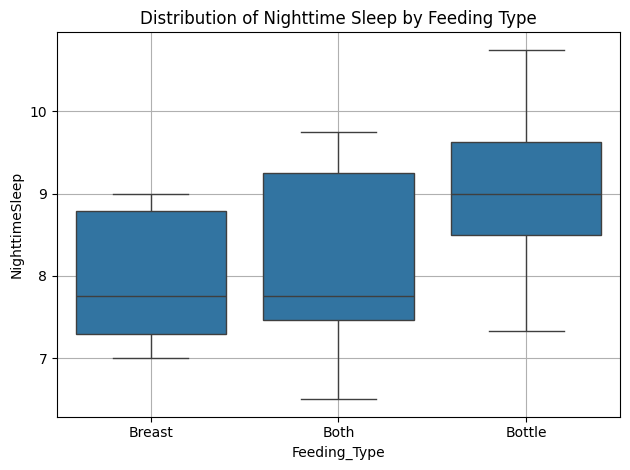

In [6]:
sns.boxplot(data=filtered_df, x="Feeding_Type", y="NighttimeSleep")
plt.title('Distribution of Nighttime Sleep by Feeding Type')
plt.grid(True)
plt.tight_layout()
plt.show()

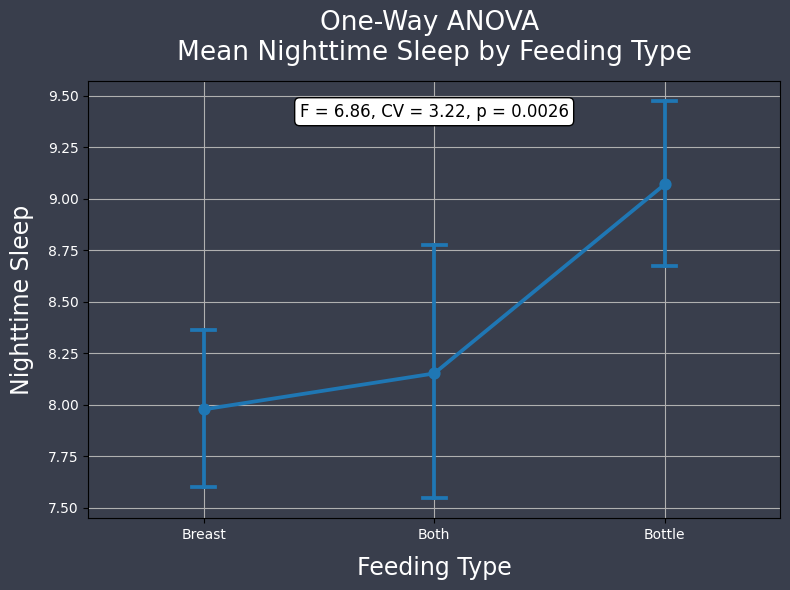

In [7]:
order = ['Breast', 'Both', 'Bottle']

# Create figure with background
plt.figure(figsize=(8, 6), facecolor='#393E4C')
ax = plt.gca()
ax.set_facecolor('#393E4C')

# Point plot
sns.pointplot(
    data=filtered_df,
    x="Feeding_Type",
    y="NighttimeSleep",
    order=order,
    errorbar=('ci', 95),
    capsize=0.1,
    ax=ax
)

# Annotate ANOVA values directly inside plot
anova_result_text = f"F = {f_stat:.2f}, CV = {f_critical:.2f}, p = {p_val:.4f}"
ax.annotate(anova_result_text,
            xy=(0.5, 0.95), xycoords='axes fraction',  # relative position in plot
            ha='center', va='top',
            fontsize=12, bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))

# Title and axis labels
plt.title('One-Way ANOVA \nMean Nighttime Sleep by Feeding Type', fontsize=19, color='white', pad=15)
plt.xlabel('Feeding Type', fontsize=17, color='white', labelpad=10)
plt.ylabel('Nighttime Sleep', fontsize=17, color='white', labelpad=10)

# Tick label colors
plt.xticks(color='white')
plt.yticks(color='white')

plt.grid(True)
plt.tight_layout()
plt.show()


In [8]:
# Run Tukey's HSD test
tukey_result = pairwise_tukeyhsd(
    endog=filtered_df['NighttimeSleep'],
    groups=filtered_df['Feeding_Type'],
    alpha=0.05
)

# Convert the summary to a styled DataFrame
tukey_df = pd.DataFrame(
    tukey_result._results_table.data[1:],  # skip header row
    columns=tukey_result._results_table.data[0]
)

# Rename columns for clarity
tukey_df.columns = ['Group 1', 'Group 2', 'Mean Diff', 'p-value', 'Lower CI', 'Upper CI', 'Significant?']

# Format numeric values for cleaner look
tukey_df['Mean Diff'] = tukey_df['Mean Diff'].astype(float).round(2)
tukey_df['p-value'] = tukey_df['p-value'].astype(float).round(4)
tukey_df['Lower CI'] = tukey_df['Lower CI'].astype(float).round(2)
tukey_df['Upper CI'] = tukey_df['Upper CI'].astype(float).round(2)

# Output the cleaned table (Power BI will display this as a table visual)
tukey_df

,Group 1,Group 2,Mean Diff,p-value,Lower CI,Upper CI,Significant?
0,Both,Bottle,0.92,0.0308,0.07,1.76,True
1,Both,Breast,-0.17,0.8817,-1.06,0.71,False
2,Bottle,Breast,-1.09,0.0037,-1.86,-0.32,True


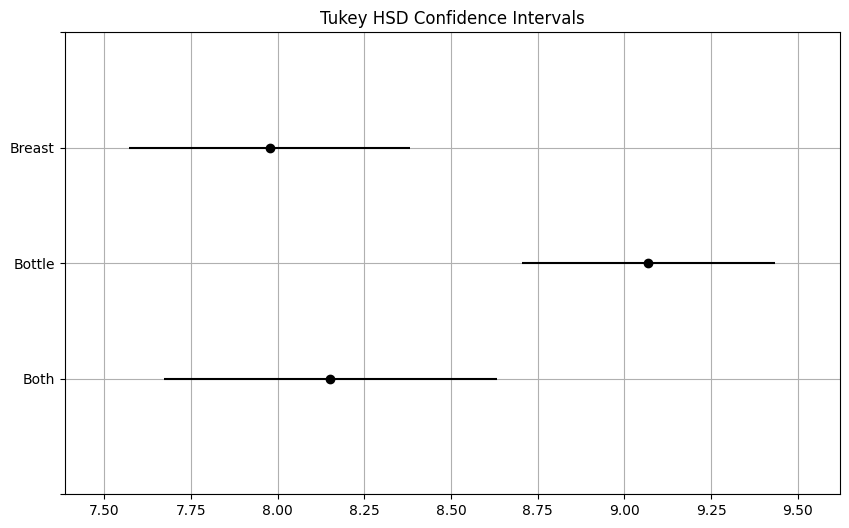

In [9]:
tukey_result.plot_simultaneous()
plt.title("Tukey HSD Confidence Intervals")
plt.grid(True)
plt.show()

# Chi-Square Test of Independence - Good/Bad Sleep

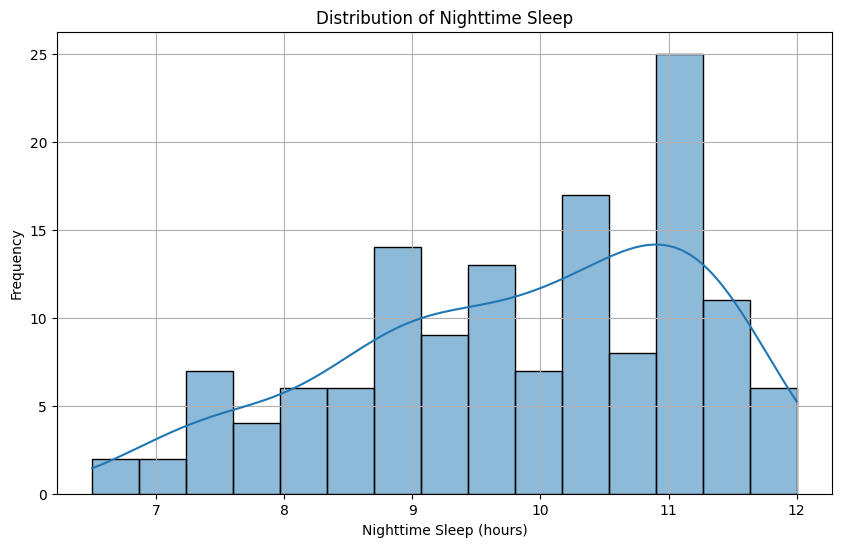

In [10]:
# Plot our Nighttime Sleep so we can determine a good reference for "Good Sleep"

plt.figure(figsize=(10, 6))
sns.histplot(stats_df['NighttimeSleep'], bins=15, kde=True)
plt.title("Distribution of Nighttime Sleep")
plt.xlabel("Nighttime Sleep (hours)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [11]:
# Set "Good" Sleep
stats_df['GoodBadSleep'] = stats_df['NighttimeSleep'].apply(lambda x: "Good" if x >= 10.5 else "Bad")

# Step 1: Create a contingency table
contingency = pd.crosstab(stats_df['Feeding_Type'], stats_df['GoodBadSleep'])

# Step 2: Chi-square test of independence
chi2_stat, p, dof, expected = stats.chi2_contingency(contingency)

P-value < 0.05 → Feeding_Type and GoodBadSleep are not independent.

Standardized residuals > 2 or < -2 indicate statistically significant cells.

Positive residual → more observations than expected.

Negative residual → fewer observations than expected.

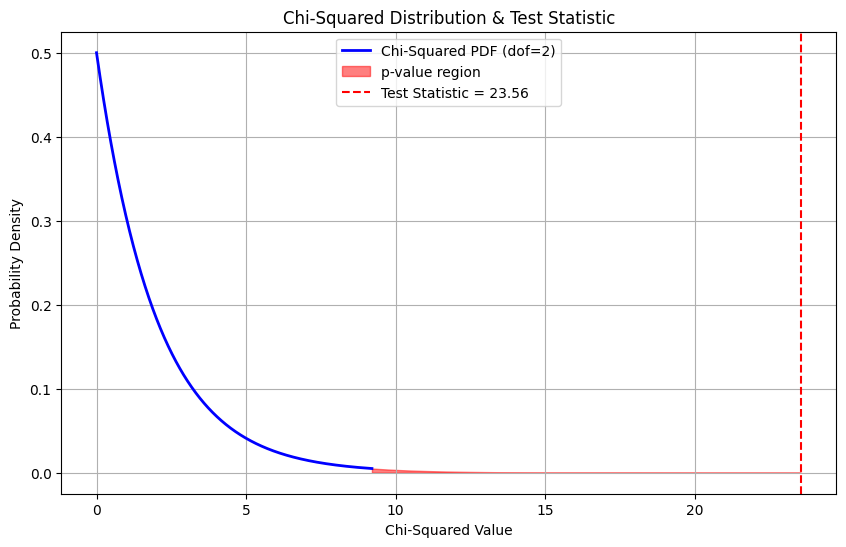

In [12]:
# STEP 3: Chi-Squared Distribution Plot
x = np.linspace(0, stats.chi2.ppf(0.99, dof), 1000)

plt.figure(figsize=(10, 6))
plt.plot(x, stats.chi2.pdf(x, dof), 'b-', lw=2, label=f'Chi-Squared PDF (dof={dof})')

# Shade area for p-value region
x_fill = np.linspace(chi2_stat, stats.chi2.ppf(0.99, dof), 100)
plt.fill_between(x_fill, stats.chi2.pdf(x_fill, dof), color='red', alpha=0.5, label='p-value region')

# Vertical line at test statistic
plt.axvline(chi2_stat, color='red', linestyle='--', label=f'Test Statistic = {chi2_stat:.2f}')

plt.title("Chi-Squared Distribution & Test Statistic")
plt.xlabel("Chi-Squared Value")
plt.ylabel("Probability Density")
plt.legend()
plt.grid(True)
plt.show()

Chi-square statistic: 23.5598129775345
Degrees of freedom: 2
P-value: 7.656876011708523e-06


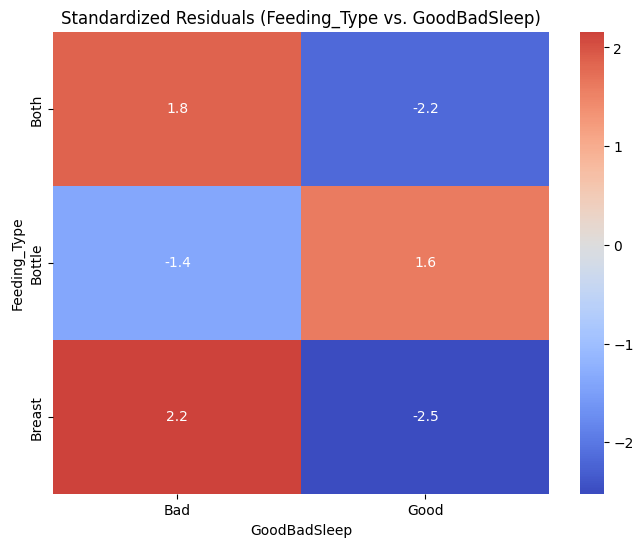

In [13]:
# Step 4: Calculate standardized residuals
observed = contingency.values
residuals = (observed - expected) / (expected ** 0.5)

# Step 5: Display results
print("Chi-square statistic:", chi2_stat)
print("Degrees of freedom:", dof)
print("P-value:", p)

# Step 6: Create a heatmap of standardized residuals
residuals_df = pd.DataFrame(residuals, index=contingency.index, columns=contingency.columns)

plt.figure(figsize=(8, 6))
sns.heatmap(residuals_df, annot=True, cmap="coolwarm", center=0)
plt.title("Standardized Residuals (Feeding_Type vs. GoodBadSleep)")
plt.xlabel("GoodBadSleep")
plt.ylabel("Feeding_Type")
plt.show()

# Logistic regression

In [14]:
# Dropping columns we don't want in our model
stats_df.drop(columns=['Date','NighttimeSleep'], inplace=True)

# Apply one-hot encoding to the 'Feeding_Type' column for later stats work
stats_df = pd.get_dummies(stats_df, columns=['Feeding_Type'])
stats_df

,Birth_Week,Birth_Month,CurDayOunces,PrevDayOunces,NumbofDayNaps,Weight_Pounds,DaytimeSleep,GoodBadSleep,Feeding_Type_Both,Feeding_Type_Bottle,Feeding_Type_Breast
0,2,1,17.610619,17.615044,3,8.323958,7.00,Bad,False,False,True
1,2,1,17.615044,19.774336,3,8.362500,6.75,Bad,False,False,True
2,2,1,19.774336,20.223404,3,8.401042,5.50,Bad,False,False,True
3,3,1,20.223404,18.755319,4,8.439583,6.42,Bad,True,False,False
4,3,1,18.755319,16.085106,4,8.478125,6.50,Bad,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...
132,24,6,24.000000,30.000000,3,14.281250,3.75,Good,False,True,False
133,24,6,30.000000,28.000000,3,14.281250,3.00,Good,False,True,False
134,24,6,28.000000,26.500000,3,14.281250,3.08,Good,False,True,False
135,24,6,26.500000,27.000000,3,14.281250,3.25,Good,False,True,False


In [15]:
# Define our target column and then drop it
y = stats_df['GoodBadSleep']
X = stats_df.drop(columns=['GoodBadSleep'])

# Convert boolean columns to integers
X = X.astype({col: int for col in X.select_dtypes('bool').columns})

# Train/test split
# test_size -> 20% to be used for testing
# random_state -> setting the sequence for the random test selection
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create pipeline object that 1.) scales the data and 2.) creates the logistic regression model on that data
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000))
])

# Fit and run the model with our input featers to learn patterns
pipeline.fit(X_train, y_train)

# Run test data through same pipeline object
# predict probability of "Good Sleep", [:, 1] <- NumPy slicing
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]

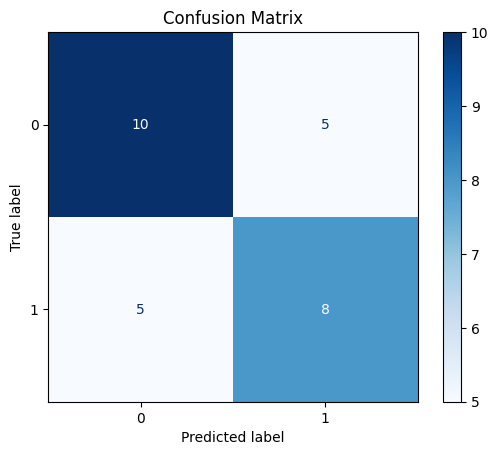

In [16]:
# Visualizes true vs. predicted labels
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

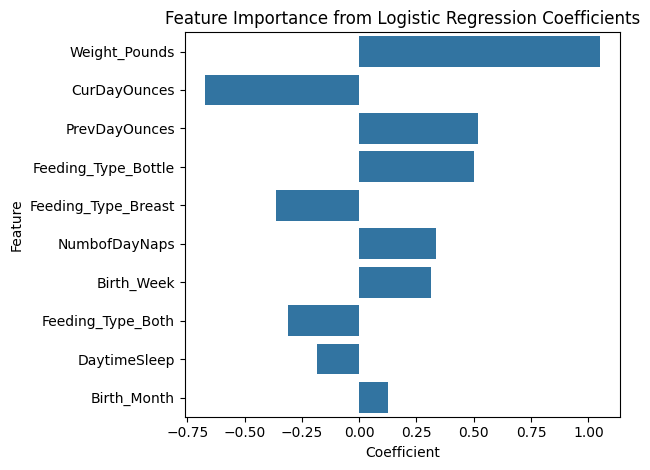

In [17]:
#Shows how much each feature influences the prediction.
coefficients = pipeline.named_steps['logreg'].coef_[0]
features = X.columns 
coef_df = pd.DataFrame({'Feature': features, 'Coefficient': coefficients})

# Plotting
coef_df.sort_values(by='Coefficient', key=abs, ascending=False, inplace=True)
sns.barplot(data=coef_df, x='Coefficient', y='Feature')
plt.title("Feature Importance from Logistic Regression Coefficients")
plt.tight_layout()
plt.show()

In [18]:
# Metrics and AUC
classification_rep = classification_report(y_test, y_pred, output_dict=True)

# Convert to df for better display
classification_rep = pd.DataFrame(classification_rep).transpose()

classification_rep
#Precision - Of all scenerios predicted to have good sleep, how many actually were?
#Recall	- Of all scenerios to actually have good sleep, how many did we correctly predict?
#F1-score - The balance of precision and recall 
#support - tells you how many actual instances of each class, Good or Bad sleep, were used
#Accuracy - Overall % of predictions that were correct

,precision,recall,f1-score,support
Bad,0.666667,0.666667,0.666667,15.000000
Good,0.615385,0.615385,0.615385,13.000000
accuracy,0.642857,0.642857,0.642857,0.642857
macro avg,0.641026,0.641026,0.641026,28.000000
weighted avg,0.642857,0.642857,0.642857,28.000000


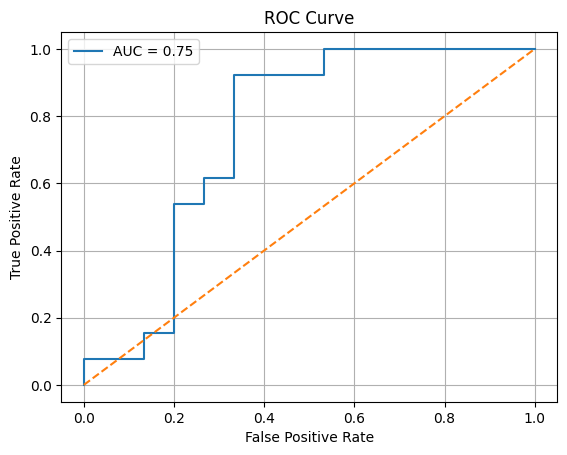

(              precision    recall  f1-score    support
 Bad            0.666667  0.666667  0.666667  15.000000
 Good           0.615385  0.615385  0.615385  13.000000
 accuracy       0.642857  0.642857  0.642857   0.642857
 macro avg      0.641026  0.641026  0.641026  28.000000
 weighted avg   0.642857  0.642857  0.642857  28.000000,
 np.float64(0.7487179487179487))

In [19]:
y_test = y_test.map({'Bad': 0, 'Good': 1})
roc_auc = roc_auc_score(y_test, y_prob)
#ROC = Receiver Operating Characteristic
#AUC = Area Under the Curve (ranges from 0.5 to 1.0, wtih 0.5 no better than guessing and 1.0 being Excellent)
# Uses y_prob instead of y_pred to test probability scores (00 to 1.0) to see how well the model ranks likelihoods. 
# Plot ROC curve. y_pred is either 0 or 1.
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

classification_rep, roc_auc